In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn

import numpy as np
import torch.optim as optim
import torch.utils.data as data

In [2]:
covid_hospitalization_data = pd.read_csv("/Users/alex/Documents/Covid_Data/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW_.csv")
covid_hospitalization_data["date"] = pd.to_datetime(covid_hospitalization_data["date"])
MA_data = covid_hospitalization_data[covid_hospitalization_data['state']=='MA'].sort_values('date')
MA_data.head()

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,previous_day_admission_pediatric_covid_confirmed_5_11_coverage,previous_day_admission_pediatric_covid_confirmed_unknown,previous_day_admission_pediatric_covid_confirmed_unknown_coverage,staffed_icu_pediatric_patients_confirmed_covid,staffed_icu_pediatric_patients_confirmed_covid_coverage,staffed_pediatric_icu_bed_occupancy,staffed_pediatric_icu_bed_occupancy_coverage,total_staffed_pediatric_icu_beds,total_staffed_pediatric_icu_beds_coverage,Demo | State Geographic Boundaries
15475,MA,2020-03-27,0,0,1,0,0,1,0.0,1,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
17144,MA,2020-03-28,0,0,1,0,0,1,0.0,1,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
15869,MA,2020-03-29,0,0,2,0,0,2,0.0,2,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
20763,MA,2020-03-30,0,0,6,0,0,6,0.0,5,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
16094,MA,2020-03-31,0,0,11,0,0,11,0.0,9,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN


In [3]:
target_variable = ['total_adult_patients_hospitalized_confirmed_covid']

pa_MA_data = MA_data[[target_variable[0]]].dropna().values.astype('float32')
len(pa_MA_data)

1056

In [4]:
train_size = int(len(pa_MA_data) * 0.67)
test_size = len(pa_MA_data) - train_size
train, test = pa_MA_data[:train_size], pa_MA_data[train_size:]

In [5]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [6]:
lookback = 7
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([700, 7, 1]) torch.Size([700, 7, 1])
torch.Size([342, 7, 1]) torch.Size([342, 7, 1])


/var/folders/4x/v484jjj95cn1j9m1kqx7srth0000gn/T/ipykernel_71799/778121417.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343680142/work/torch/csrc/utils/tensor_new.cpp:248.)
  return torch.tensor(X), torch.tensor(y)


In [7]:
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [8]:
class MAPELoss(nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()

    def forward(self, y, y_hat):
        mape = torch.abs(y - y_hat) / torch.abs(y)
        mape = torch.mean(mape)
        return mape

In [9]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = MAPELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = loss_fn(y_pred, y_train)
        y_pred = model(X_test)
        test_rmse = loss_fn(y_pred, y_test)
    print("Epoch %d: train MAPE %.4f, test MAPE %.4f" % (epoch, train_rmse, test_rmse))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch 0: train MAPE 484.9396, test MAPE 417.6397
Epoch 100: train MAPE 7.1895, test MAPE 6.0629
Epoch 200: train MAPE 2.0000, test MAPE 1.5349
Epoch 300: train MAPE 0.7127, test MAPE 0.3897
Epoch 400: train MAPE 0.3320, test MAPE 0.0942
Epoch 500: train MAPE 0.2159, test MAPE 0.0532
Epoch 600: train MAPE 0.1526, test MAPE 0.0390
Epoch 700: train MAPE 0.1194, test MAPE 0.0372
Epoch 800: train MAPE 0.1010, test MAPE 0.0419
Epoch 900: train MAPE 0.0851, test MAPE 0.0376
Epoch 1000: train MAPE 0.0771, test MAPE 0.0356
Epoch 1100: train MAPE 0.0744, test MAPE 0.0384
Epoch 1200: train MAPE 0.0690, test MAPE 0.0363
Epoch 1300: train MAPE 0.0716, test MAPE 0.0348
Epoch 1400: train MAPE 0.0670, test MAPE 0.0371
Epoch 1500: train MAPE 0.0630, test MA

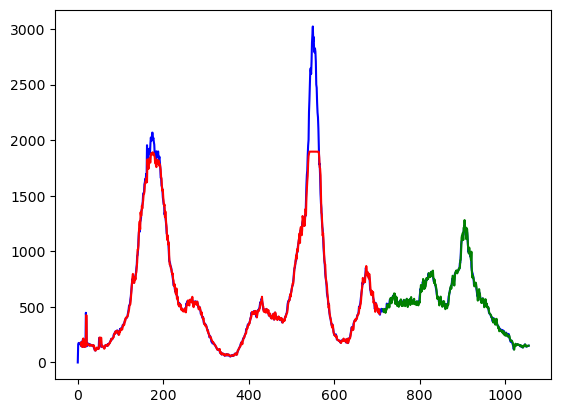

In [10]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(pa_MA_data) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(pa_MA_data) * np.nan
    test_plot[train_size+lookback:len(pa_MA_data)] = model(X_test)[:, -1, :]
# plot
plt.plot(pa_MA_data, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

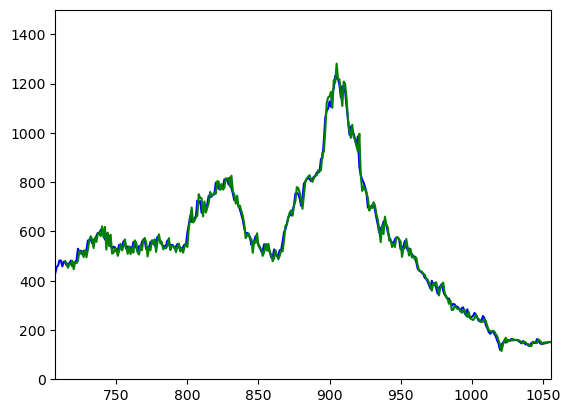

In [11]:
plt.plot(pa_MA_data, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.xlim([len(pa_MA_data) - test_size,len(pa_MA_data)])
plt.ylim([0,1500])
plt.show()

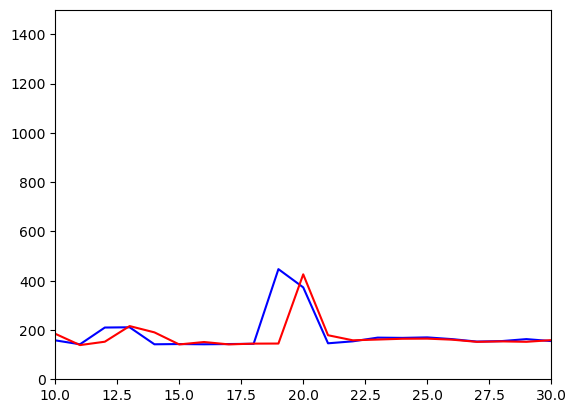

In [12]:
plt.plot(pa_MA_data, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.xlim([10,30])
plt.ylim([0,1500])
plt.show()